In [12]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
         "text.color" : "c"}
plt.rcParams.update(params)#setup for dark theme

import pandas as pd
from numpy import linalg
from sklearn.decomposition import PCA
from scipy.io import loadmat

from matplotlib.patches import Ellipse
#import matplotlib.transforms as transforms

from collections import defaultdict
#from PIL import Image
#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

import scipy.stats as sstats 
#from tqdm import tqdm
from sklearn import (metrics, datasets, decomposition, ensemble, manifold, random_projection, preprocessing)

In [13]:
#standaryzacja danych zad1(b) 
def my_standarize(X):
    m = np.mean(X, 0).reshape(1, -1)#wymiary nieznane
    s = np.std(X, 0).reshape(1, -1)
    
    return (X - m) / (s + 1e-10)

Zadanie 2. (2 punkty)
Zapoznaj się z dołączonymi do listy zadań danymi (pochodzącymi z bazy danych AR Face
Database 1 stworzonej przez prof. Aleixa Martineza z Ohio State University i udostępnionej
przez niego na potrzeby naszego wykładu). Przygotowany przeze mnie zbiór danych
zawiera odpowiednio przeskalowane zdjęcia twarzy o rozdzielczości 82 x 60 pikseli w 256
odcieniach szarości każdy (zatem zdjęcie twarzy można utożsamić z punktem przestrzeni
82 x 60 = 4920 wymiarowej). Wczytaj pierwszy zestaw danych (zawierający 250 zdjęć –
po 5 zdjęć każdej z 50 osób), spróbuj zredukować ich wymiarowość. Dokładnie
przeanalizuj wyniki (jak można interpretować uzyskane wektory własne?).

In [14]:
#wczytywanie danych, 
faces_train = loadmat('ReducedImagesForTraining.mat',matlab_compatible=True)['images']
faces_test = loadmat('ReducedImagesForTesting.mat',matlab_compatible=True)['images']

In [15]:
print(faces_train[:5,:])
print('shape =', faces_train.shape)

[[ 34.16666667 230.          34.08333333 ...  36.41666667  49.75
   73.41666667]
 [ 31.5         53.25        29.91666667 ...  40.66666667  35.58333333
   42.58333333]
 [ 31.75        38.33333333  30.5        ...  38.75        37.25
   41.41666667]
 [ 34.          35.33333333  32.66666667 ...  58.83333333  38.08333333
   38.91666667]
 [ 36.08333333  33.33333333  33.75       ...  37.41666667  80.16666667
   85.58333333]]
shape = (4920, 250)


In [16]:
faces_train = faces_train.T
faces_test = faces_test.T #transpozycja do zgody wymiarow
#zdjecia sa teraz kolumnowow

In [17]:
%%time
sigma = np.cov(my_standarize(faces_train).T)
v_faces, w_faces = linalg.eig(sigma)

CPU times: user 5min 48s, sys: 4.57 s, total: 5min 53s
Wall time: 1min 37s


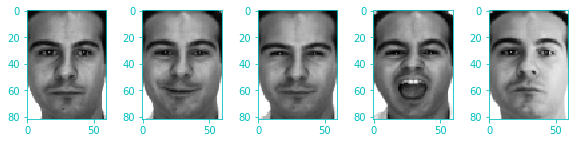

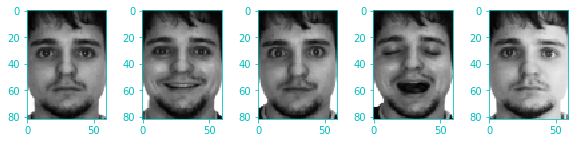

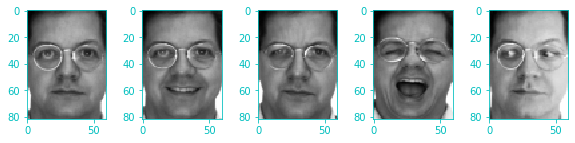

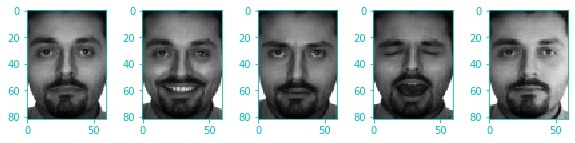

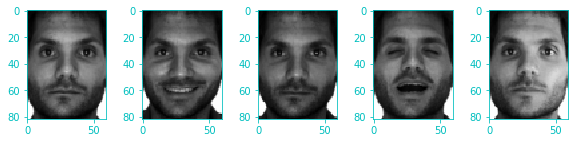

In [18]:
for i in range(5):
    f, ax = plt.subplots(1,5, figsize=(10,2))
    for j in range(5):
        img = faces_train[5 * i + j].reshape(60,82).T
        ax[j].imshow(img, cmap='gray')

In [19]:
#redukcja przez pca do 60 wymiarow
train_pca = np.dot(my_standarize(faces_train), 
                   np.dot(w_faces[:, :60], np.diag(1/np.sqrt(v_faces[:60]))))
train_pca = np.real(train_pca)

In [20]:
train_pca.shape

(250, 60)

In [21]:
train_pca

array([[ 0.65600785,  1.15416492,  0.23062552, ..., -0.96038848,
         0.59136465, -0.14159204],
       [ 0.62768709,  1.144741  ,  0.37310728, ..., -0.92170132,
         0.69149669,  0.19753574],
       [ 0.58800568,  1.20981494,  0.12271527, ..., -1.68076975,
         1.02188935,  0.85149416],
       ...,
       [ 0.61214738,  1.04399255,  1.09757426, ...,  0.11110983,
        -0.57279047,  0.21924823],
       [ 0.33579386,  1.13500642,  0.51427668, ...,  0.4597473 ,
        -0.12649136, -1.64445613],
       [ 2.37376653, -0.7535619 ,  0.30246122, ...,  0.8646985 ,
        -0.55789931,  1.89072438]])

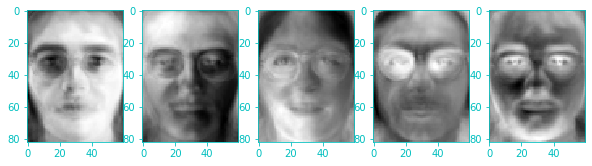

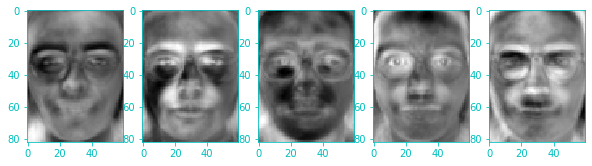

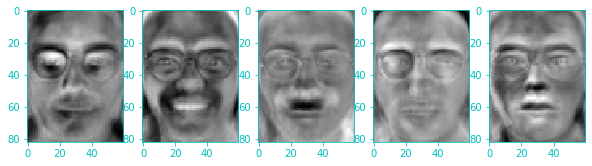

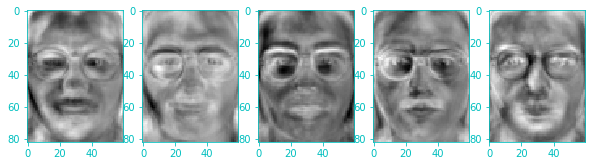

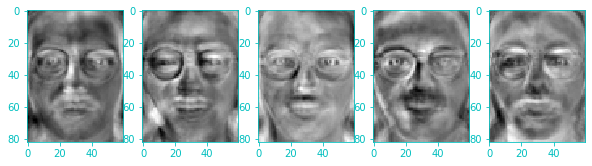

In [23]:
for i in range(5):
    f, ax = plt.subplots(1,5, figsize=(10,10))
    for j in range(5):
        img = np.real(w_faces[:,5*i+j]).reshape(60,82).T
        ax[j].imshow(img, cmap='gray')
#wektory wlasne wyznaczaja nowe uklad wspolrzednych na ktory rzutujemy dane wejsciowe

Zadanie 3. (2 punkty)
Zaimplementuj prostą metodę rozpoznawania twarzy:
- wczytane są zdjęcia wzorcowe (5 zdjęć każdej z 50 osób), czyli 250 wektorów
4920-wymiarowych x 1 , x 2 , ..., x 250 ∈ R 4920 ,
- wiadomo które zdjęcia wzorcowe odpowiadają którym osobom (w zbiorze danych
zdjęcia osób są zapisane kolejno: 5 zdjęć osoby nr 1, 5 zdjęć osoby nr 2, ..., 5 zdjęć
osoby nr 50), co można określić funkcją osoba(x k ) = (k-1) div 5 + 1,
- na wejściu podawane jest zdjęcie nieznanej osoby, czyli wektor 4920 wymiarowy y
∈ R 4920 ,
- dla wektora y należy wyznaczyć najbliższy mu wektor x k , dla k = 1, 2, ..., 250,
(najbliższy w sensie odległości euklidesowej w R 4920 ),
- jeżeli odległość między y a x k nie przekracza pewnego ustalonego progu, to można
uznać, że y jest zdjęciem twarzy osoby osoba(x k ).
Wczytaj drugi zestaw danych (zawierający 100 zdjęć – po 2 zdjęcia każdej z 50 osób).
Przetestuj na tym zestawie danych efektywność zaimplementowanej metody (zdjęcia
wzorcowe pochodzą z pierwszego zestawu danych, drugi zestaw danych jest używany
tylko do testów). Dokładnie przeanalizuj wyniki.

In [34]:
#wektory własne mamy policzone na samym zbiorze treningowym
def classify(y, X=faces_train, PCA=False):
    if PCA:
        X, y = standarize(X), standarize(y)
        X = np.dot(my_standarize(X), 
                   np.dot(w_faces[:, :PCA], np.diag(1/np.sqrt(v_faces[:PCA]))))
        y = np.dot(my_standarize(y), 
                   np.dot(w_faces[:, :PCA], np.diag(1/np.sqrt(v_faces[:PCA]))))
        y = np.real(y)
        X = np.real(X)
    dists = np.sqrt(np.sum((X - y) ** 2, axis=1))
    closest = np.argmin(dists)
    return closest // 5, dists[closest]

def classify_all(X=faces_train, y=faces_test, PCA=False):
    if PCA:
        X, y = my_standarize(X), my_standarize(y)
        X = np.dot(my_standarize(X), 
                   np.dot(w_faces[:, :PCA], np.diag(1/np.sqrt(v_faces[:PCA]))))
        y = np.dot(my_standarize(y), 
                   np.dot(w_faces[:, :PCA], np.diag(1/np.sqrt(v_faces[:PCA]))))
        y = np.real(y)
        X = np.real(X)
    dists = -2 * np.dot(y, X.T) + np.sum(X.T**2, axis=0)
    closest = np.argmin(dists, axis=1) // 5#5 zdjec osoby
    return closest

def show_closest(img, X=faces_train, PCA=False):
    person, dist = classify(img, X, PCA)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 5))
    axes[0].imshow(img.reshape(60, 82).T, cmap='gray')
    axes[0].set_title('sample')
    axes[1].imshow(faces_train[person].reshape(60, 82).T, cmap='gray')
    axes[1].set_title(f'closest: {dist:.3f}')

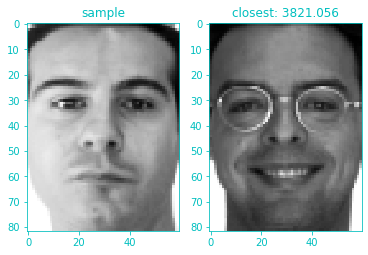

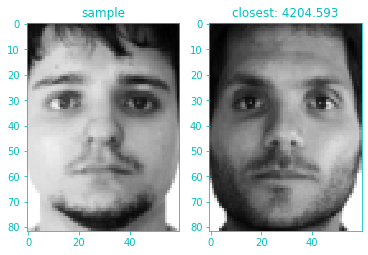

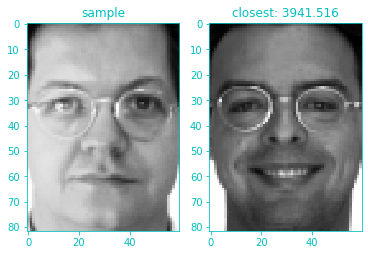

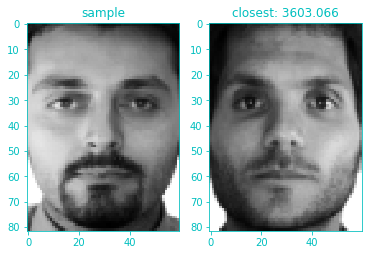

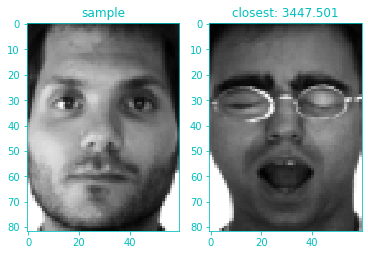

In [25]:
for i in range(5):
    show_closest(faces_test[2*i])


In [26]:
predictions = classify_all(X=faces_train, y=faces_test)
y1 = np.array([i // 2 for i in range(100)])
print(f'Accuracy: {sum(predictions == y1)}%')

Accuracy: 17%


Zadanie 4. (2 punkty)
Zmień metodę rozpoznawania twarzy z poprzedniego zadania w taki sposób, że zamiast
pracować w przestrzeni R 4920 będziemy pracować w przestrzeni mniej wymiarowej
(wyznaczonej przez redukcję wymiarowości pierwszego zestawu danych metodą PCA).
Porównaj tę metodę z metodą oryginalną (używając do testów drugiego zestawu danych).
Dokładnie przeanalizuj wyniki.

In [27]:
faces_train.shape

(250, 4920)

In [35]:
pca_res = np.zeros((45,2), dtype=int)
y1 = np.array([i // 2 for i in range(100)])
for j in range(1,46):
    predictions = classify_all(X=faces_train, y=faces_test, PCA=j)
    sum1 = sum(predictions == y1)    
    pca_res[j-1, :] = np.array([j,sum1])
print(pca_res)

[[  1   4]
 [  2   7]
 [  3  23]
 [  4  42]
 [  5  58]
 [  6  69]
 [  7  71]
 [  8  79]
 [  9  83]
 [ 10  85]
 [ 11  93]
 [ 12  93]
 [ 13  95]
 [ 14  95]
 [ 15  97]
 [ 16  98]
 [ 17  99]
 [ 18  99]
 [ 19  99]
 [ 20  99]
 [ 21  98]
 [ 22  98]
 [ 23  97]
 [ 24  98]
 [ 25  98]
 [ 26  99]
 [ 27  99]
 [ 28  99]
 [ 29  99]
 [ 30  99]
 [ 31  99]
 [ 32  99]
 [ 33 100]
 [ 34 100]
 [ 35 100]
 [ 36 100]
 [ 37 100]
 [ 38 100]
 [ 39 100]
 [ 40 100]
 [ 41 100]
 [ 42 100]
 [ 43 100]
 [ 44 100]
 [ 45 100]]


Zadanie 5. (2 punkty)
Zamiast proponowanej prostej metody rozpoznawania twarzy użyj klasyfikatora KNN.
Porównaj skuteczność klasyfikacji dla różnych k, dla danych oryginalnych i danych
zredukowanych (dla różnej liczby wymiarów). Porównanie zrób metodą cross-validation
dla połączonych obu zestawów danych.

In [36]:

def KNN(k, labels, X, y, PCA=False):
    if PCA:
        X, y = my_standarize(X), my_standarize(y)
        X = np.dot(my_standarize(X), 
                   np.dot(w_faces[:, :PCA], np.diag(1/np.sqrt(v_faces[:PCA]))))
        y = np.dot(my_standarize(y), 
                   np.dot(w_faces[:, :PCA], np.diag(1/np.sqrt(v_faces[:PCA]))))
        
    dists = -2 * np.dot(y, X.T) + np.sum(X.T ** 2, axis=0)
    closest = np.argsort(dists, axis=1)
    closest = closest[:, :k]
    closest = labels[closest]
    targets = sstats.mode(closest, axis=1)[0]

    return targets

In [37]:
all_photos = np.concatenate((faces_train,faces_test))

In [38]:
# try knn
ys = np.array([i // 2 for i in range(len(faces_test))])
xs = np.array([i // 5 for i in range(len(faces_train))])
knn1 = KNN(1, labels=xs, X=faces_train, y=faces_test).ravel()
print(f'Without PCA: {sum(knn1 == ys)}%')
knn2 = KNN(1, labels=xs, X=faces_train, y=faces_test, PCA=33).ravel()
print(f'PCA: {sum(knn2 == ys)}%')


Without PCA: 17%
PCA: 100%


In [51]:
def cross_validation(X, no=10, PCA=False):
    ks = np.arange(1,14,2)
    print(f'dividing dataset on {no} parts')
    for k in ks:
        avg_score = 0
        indices = np.random.uniform(0, no, len(X)).astype(int)
        for i in range(no):
            x_train = X[indices != i]
            y_train = np.array([i // 7 for i, b in enumerate(indices != i) if b])
            
            x_test = X[indices == i]
            y_test = np.array([i // 7 for i, b in enumerate(indices == i) if b])

            preds = KNN(k=k, labels=y_train, X=x_train, y=x_test, PCA=PCA).ravel()
            score = (preds == y_test).mean()
            avg_score += score        
        print(f'k = {k} \t mean_acc: {avg_score / no * 100 :.3f}%')
    

In [52]:
_=cross_validation(X=all_photos, no=6, PCA=False)


dividing dataset on 6 parts
k = 1 	 mean_acc: 43.170%
k = 3 	 mean_acc: 31.096%
k = 5 	 mean_acc: 26.944%
k = 7 	 mean_acc: 21.647%
k = 9 	 mean_acc: 15.751%
k = 11 	 mean_acc: 15.427%
k = 13 	 mean_acc: 10.311%


In [53]:
_=cross_validation(X=all_photos, no=6, PCA=33)


dividing dataset on 6 parts
k = 1 	 mean_acc: 56.108%
k = 3 	 mean_acc: 42.372%
k = 5 	 mean_acc: 38.882%
k = 7 	 mean_acc: 33.054%
k = 9 	 mean_acc: 28.123%
k = 11 	 mean_acc: 25.951%
k = 13 	 mean_acc: 28.603%


In [54]:
_=cross_validation(X=all_photos, no=15, PCA=33)


dividing dataset on 15 parts
k = 1 	 mean_acc: 58.199%
k = 3 	 mean_acc: 45.426%
k = 5 	 mean_acc: 42.609%
k = 7 	 mean_acc: 37.451%
k = 9 	 mean_acc: 35.154%
k = 11 	 mean_acc: 31.593%
k = 13 	 mean_acc: 27.834%
